## bureau balance time series feature extraction

Train GRU network on bureau balance time series data. Save prediction to be used as features in final training.

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
import gc

import os
print(os.listdir("../input"))
    
gc.enable()

['download_command.txt', 'application_test.csv', 'HomeCredit_columns_description.csv', 'POS_CASH_balance.csv', 'credit_card_balance.csv', 'installments_payments.csv', 'application_train.csv', 'bureau.csv', 'previous_application.csv', 'bureau_balance.csv', 'sample_submission.csv']


Read bureau balance data and create features.

In [2]:
buro = pd.read_csv('../input/bureau.csv')
buro_id_map = buro.groupby('SK_ID_BUREAU')['SK_ID_CURR'].min()
buro.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [3]:
#buro has 1716428 SK_ID_BUREAU
#bubl has 817395 SK_ID_BUREAU
#942074 buro_id in buro not present in bubl
#43041 buro_id in bubl not present in buro
#interesting...
bubl = pd.read_csv('../input/bureau_balance.csv')
bubl['STATUS_COMPLETE'] = 0
bubl['STATUS_COMPLETE'].loc[bubl['STATUS']=='C'] = 1
bubl['STATUS_X'] = 0
bubl['STATUS_X'].loc[bubl['STATUS']=='X'] = 1
bubl['STATUS_DPD'] = -1
bubl['STATUS_DPD'].loc[bubl['STATUS'].isin(['0','1','2','3','4','5'])] = bubl['STATUS']
bubl['STATUS_DPD'] = bubl['STATUS_DPD'].astype('int32')
bubl['SK_ID_CURR'] = bubl['SK_ID_BUREAU'].map(buro_id_map)
bubl = bubl.loc[bubl['SK_ID_CURR'].notna()]
bubl['SK_ID_CURR'] = bubl['SK_ID_CURR'].astype('int')
bubl.head()

/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_74627/3190563928.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bubl['STATUS_COMPLETE'].loc[bubl['STATUS']=='C'] = 1
/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_74627/3190563928.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bubl['STATUS_X'].loc[bubl['STATUS']=='X'] = 1
/var/folders/cm/wy6qs4m10756wz1k16wsjx000000gn/T/ipykernel_74627/3190563928.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/i

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS,STATUS_COMPLETE,STATUS_X,STATUS_DPD,SK_ID_CURR
0,5715448,0,C,1,0,-1,380361
1,5715448,-1,C,1,0,-1,380361
2,5715448,-2,C,1,0,-1,380361
3,5715448,-3,C,1,0,-1,380361
4,5715448,-4,C,1,0,-1,380361


Read target from main table.

In [4]:
data_app = pd.read_csv('../input/application_train.csv',usecols=['SK_ID_CURR','TARGET'])
data_test = pd.read_csv('../input/application_test.csv',usecols=['SK_ID_CURR'])
data_app.shape, data_test.shape

((307511, 2), (48744, 1))

In [5]:
trn_id = data_app['SK_ID_CURR'].loc[data_app.SK_ID_CURR.isin(bubl.SK_ID_CURR)]
test_id = data_test['SK_ID_CURR'].loc[data_test['SK_ID_CURR'].isin(bubl.SK_ID_CURR)]
trn_id.shape, test_id.shape

((92231,), (42311,))

Split train and test set. Groupby ID and month to create time series.

In [6]:
bubl_trn = bubl.loc[bubl.SK_ID_CURR.isin(trn_id)]
bubl_test = bubl.loc[bubl.SK_ID_CURR.isin(test_id)]
num_aggregations = {
    'SK_ID_BUREAU' : ['count'],
    'STATUS_COMPLETE': ['sum'],
    'STATUS_X': ['sum'],
    'STATUS_DPD': ['sum','mean','max'],
}
bubl_trn = bubl_trn.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggregations)
bubl_test = bubl_test.groupby(['SK_ID_CURR','MONTHS_BALANCE']).agg(num_aggregations)
bubl_trn.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bubl_trn.columns.tolist()])
bubl_test.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bubl_test.columns.tolist()])
bubl_test

SK_ID_BUREAU_COUNT  STATUS_COMPLETE_SUM  \
SK_ID_CURR MONTHS_BALANCE                                            
100001     -51                              1                    0   
           -50                              1                    0   
           -49                              1                    0   
           -48                              1                    0   
           -47                              1                    0   
...                                       ...                  ...   
456250     -4                               3                    1   
           -3                               3                    1   
           -2                               3                    1   
           -1                               3                    1   
            0                               3                    1   

                           STATUS_X_SUM  STATUS_DPD_SUM  STATUS_DPD_MEAN  \
SK_ID_CURR MONTHS_BALANCE                                                  
100001     -51                        1              -1        -1.000000   
           -50                        1              -1        -1.000000   
           -49                        1              -1        -1.000000   
           -48                        1              -1        -1.000000   
           -47                        1              -1        -1.000000   
...                                 ...             ...              ...   
456250     -4                         2              -3        -1.000000   
           -3                         2              -3        -1.000000   
           -2                         1              -2        -0.666667   
           -1                         0              -1        -0.333333   
            0                         1              -2        -0.666667   

                           STATUS_DPD_MAX  
SK_ID_CURR MONTHS_BALANCE                  
100001     -51                         -1  
           -50                         -1  
           -49                         -1  
           -48                         -1  
           -47                         -1  
...                                   ...  
456250     -4                          -1  
           -3                          -1  
           -2                           0  
           -1                           0  
            0                           0  

[2492971 rows x 6 columns]

--- Sequence Length per Customer (First 5) ---
SK_ID_CURR
100002    48
100010    72
100019    17
100032    46
100033     7
dtype: int64


--- Descriptive Statistics of Sequence Lengths ---
count    92231.000000
mean        52.831358
std         27.969322
min          1.000000
25%         29.000000
50%         52.000000
75%         80.000000
max         97.000000
dtype: float64


--- Generating Visualizations ---


/Users/chenzeyu/opt/miniforge3/envs/tf26/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/chenzeyu/opt/miniforge3/envs/tf26/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


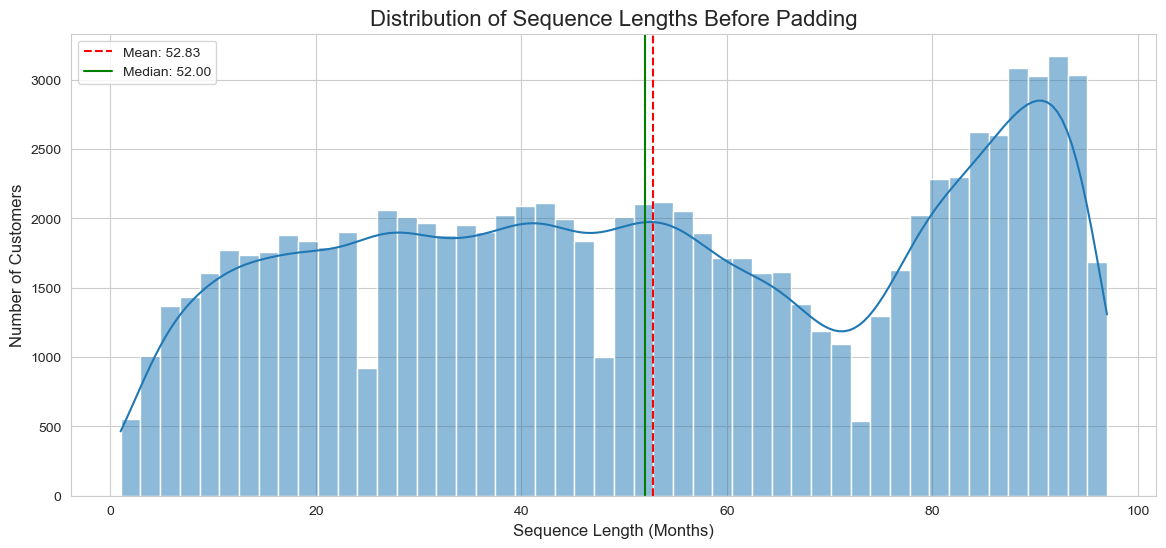

/Users/chenzeyu/opt/miniforge3/envs/tf26/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


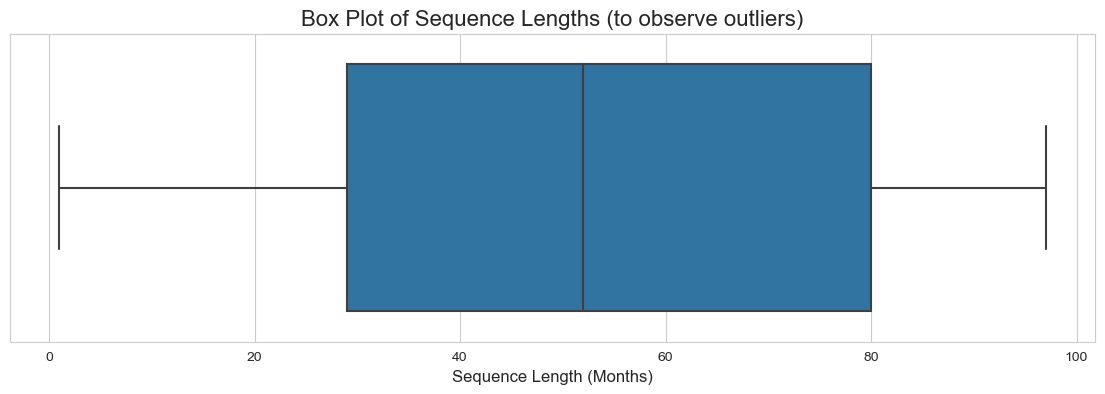

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assume bubl_trn is your MultiIndex DataFrame created from the previous step.
# If it's not a MultiIndex DataFrame, you might need to run:
# bubl_trn.reset_index(inplace=True)

# --- 1. Calculate the sequence length for each SK_ID_CURR ---

# If bubl_trn has a MultiIndex, 'SK_ID_CURR' is the first level (level=0)
if isinstance(bubl_trn.index, pd.MultiIndex):
    sequence_lengths = bubl_trn.groupby(level=0).size()
else:
    # If you have reset the index, group by the column name
    sequence_lengths = bubl_trn.groupby('SK_ID_CURR').size()
    
# sequence_lengths is now a Pandas Series where the
# Index is SK_ID_CURR and the Value is the sequence length.
print("--- Sequence Length per Customer (First 5) ---")
print(sequence_lengths.head())
print("\n" + "="*50 + "\n")


# --- 2. Display descriptive statistics ---

print("--- Descriptive Statistics of Sequence Lengths ---")
# .describe() provides a quick summary: mean, median, quartiles, etc.
print(sequence_lengths.describe())
print("\n" + "="*50 + "\n")


# --- 3. Visualize the distribution ---

print("--- Generating Visualizations ---")
# Set a nice plot style
sns.set_style("whitegrid")

# Create a figure to hold the plot
plt.figure(figsize=(14, 6))

# Plot a histogram and a Kernel Density Estimate (KDE)
sns.histplot(sequence_lengths, bins=50, kde=True)

# Add a title and labels
plt.title('Distribution of Sequence Lengths Before Padding', fontsize=16)
plt.xlabel('Sequence Length (Months)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)

# Add vertical lines for key statistics
plt.axvline(sequence_lengths.mean(), color='r', linestyle='--', label=f'Mean: {sequence_lengths.mean():.2f}')
plt.axvline(sequence_lengths.median(), color='g', linestyle='-', label=f'Median: {sequence_lengths.median():.2f}')
plt.legend()

# Display the plot
plt.show()

# Create a box plot to better see the quartiles and outliers
plt.figure(figsize=(14, 4))
sns.boxplot(x=sequence_lengths)
plt.title('Box Plot of Sequence Lengths (to observe outliers)', fontsize=16)
plt.xlabel('Sequence Length (Months)', fontsize=12)
plt.show()

Convert dataframe to 3D array (n_sample * n_time_step * n_features) for GRU network training.

In [ ]:

bubl_trn.fillna(-9.0, inplace=True)
bubl_test.fillna(-9.0, inplace=True)
# 1. 使用 unstack 将时间序列从索引“解堆”到列，并直接填充缺失值
#    level='MONTHS_BALANCE' 指定了要转换的索引层级
#    fill_value=-9 在转换过程中一步到位地填充了缺失的时间点
train_wide = bubl_trn.unstack(level='MONTHS_BALANCE', fill_value=-9)
test_wide = bubl_test.unstack(level='MONTHS_BALANCE', fill_value=-9)

# 2. 获取维度信息，为重塑 (reshape) 做准备
n_train_samples = len(train_wide.index)
n_test_samples = len(test_wide.index)
n_features = len(bubl_trn.columns)
n_timesteps = len(train_wide.columns) // n_features

# 3. 将2D宽数据重塑为3D数组，并交换维度以匹配GRU/LSTM的输入要求
#    目标维度: (样本数, 时间步长, 特征数)
train_x = train_wide.values.reshape(n_train_samples, n_features, n_timesteps)
train_x = np.swapaxes(train_x, 1, 2)

test_x = test_wide.values.reshape(n_test_samples, n_features, n_timesteps)
test_x = np.swapaxes(test_x, 1, 2)

# 4. train_y 的逻辑保持不变
#    假设 data_app 和 trn_id 已经定义
train_y = data_app['TARGET'].loc[data_app.SK_ID_CURR.isin(trn_id)]

# 5. 打印形状以验证
print("train_x shape:", train_x.shape)
print("test_x shape:", test_x.shape)
print("train_y shape:", train_y.shape)

train_x shape: (92231, 97, 6)
test_x shape: (42311, 97, 6)
train_y shape: (92231,)


Define GRU model. Use callback to evaluate auc metric.

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU,  Masking 
from keras.regularizers import l2


def build_model(time_step, n_features):
    model = Sequential()
    
    # 1. Add the Masking layer FIRST. 
    #    Specify your padding value (e.g., -9.0)
    #    The input_shape goes here.
    #model.add(Masking(mask_value=-9.0, input_shape=(time_step, n_features)))
    
    # 2. The GRU layer no longer needs the input_shape argument.
    #    It automatically gets the correct shape and the mask from the previous layer.
    model.add(GRU(4,input_shape=(time_step, n_features))) 
    model.add(Dense(1, activation='sigmoid'))
    return model

from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
import logging

class IntervalEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == (self.interval-1):
            y_pred = self.model.predict(self.X_val, verbose=0)[:,0]
            score = roc_auc_score(self.y_val, y_pred)
            print('roc score',score)

Training...

In [ ]:
from tensorflow.keras.optimizers.legacy import Adam # for mac only
# Run a 5 fold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=777)
oof_preds = np.zeros(train_x.shape[0])
sub_preds = np.zeros(test_x.shape[0])

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(train_x, train_y)):
    trn_x, val_x = train_x[trn_idx], train_x[val_idx]
    trn_y, val_y = train_y.iloc[trn_idx], train_y.iloc[val_idx]
    ival = IntervalEvaluation(validation_data=(val_x, val_y), interval=5)
    print(trn_x.shape)
    model = build_model(trn_x.shape[1],trn_x.shape[2])
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002))
    model.fit(trn_x, trn_y,
              validation_data = [val_x, val_y],
              epochs=80, batch_size=2048, 
              class_weight = {0:1,1:10},
              callbacks=[ival], verbose=1)
    
    oof_preds[val_idx] = model.predict(val_x)[:,0]
    sub_preds += model.predict(test_x)[:,0] / folds.n_splits
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx])))
  
    del model, trn_x, trn_y, val_x, val_y
    gc.collect()

(73784, 97, 6)
Epoch 1/40


2025-10-15 13:50:17.951290: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:50:18.338226: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:50:18.886495: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - ETA: 0s - loss: 1.2317

2025-10-15 13:50:20.864591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:50:20.915266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 4s 89ms/step - loss: 1.2317 - val_loss: 0.6892
Epoch 2/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2296 - val_loss: 0.6822
Epoch 3/40
15/15 [==============================] - 1s 43ms/step - loss: 1.2276 - val_loss: 0.6761
Epoch 4/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2258 - val_loss: 0.6721
Epoch 5/40
15/15 [==============================] - ETA: 0s - loss: 1.2241

2025-10-15 13:50:23.818738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:50:23.858363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


roc score 0.4816671702409967
15/15 [==============================] - 3s 234ms/step - loss: 1.2241 - val_loss: 0.6692
Epoch 6/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2224 - val_loss: 0.6666
Epoch 7/40
15/15 [==============================] - 1s 44ms/step - loss: 1.2209 - val_loss: 0.6628
Epoch 8/40
15/15 [==============================] - 1s 43ms/step - loss: 1.2194 - val_loss: 0.6611
Epoch 9/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2179 - val_loss: 0.6586
Epoch 10/40
15/15 [==============================] - 3s 236ms/step - loss: 1.2165 - val_loss: 0.6573
Epoch 11/40
15/15 [==============================] - 1s 45ms/step - loss: 1.2152 - val_loss: 0.6558
Epoch 12/40
15/15 [==============================] - 1s 44ms/step - loss: 1.2139 - val_loss: 0.6537
Epoch 13/40
15/15 [==============================] - 1s 44ms/step - loss: 1.2126 - val_loss: 0.6520
Epoch 14/40
15/15 [==============================] - 1s 43ms/step - loss: 1.2114 - va

2025-10-15 13:51:14.468513: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:51:14.611820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/15 [=====>........................] - ETA: 0s - loss: 1.1889 

2025-10-15 13:51:14.729912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 2s 109ms/step - loss: 1.1956 - val_loss: 0.6779
Epoch 2/40


2025-10-15 13:51:16.147886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:51:16.199891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 42ms/step - loss: 1.1943 - val_loss: 0.6709
Epoch 3/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1933 - val_loss: 0.6653
Epoch 4/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1926 - val_loss: 0.6597
Epoch 5/40
15/15 [==============================] - ETA: 0s - loss: 1.1919

2025-10-15 13:51:18.980271: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:51:19.018526: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


roc score 0.5496728708589994
15/15 [==============================] - 3s 209ms/step - loss: 1.1919 - val_loss: 0.6553
Epoch 6/40
15/15 [==============================] - 1s 43ms/step - loss: 1.1913 - val_loss: 0.6524
Epoch 7/40
15/15 [==============================] - 1s 41ms/step - loss: 1.1908 - val_loss: 0.6499
Epoch 8/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1903 - val_loss: 0.6475
Epoch 9/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1899 - val_loss: 0.6454
Epoch 10/40
15/15 [==============================] - 3s 195ms/step - loss: 1.1895 - val_loss: 0.6451
Epoch 11/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1891 - val_loss: 0.6446
Epoch 12/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1887 - val_loss: 0.6442
Epoch 13/40
15/15 [==============================] - 1s 43ms/step - loss: 1.1882 - val_loss: 0.6443
Epoch 14/40
15/15 [==============================] - 1s 42ms/step - loss: 1.1876 - va

2025-10-15 13:52:07.160421: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:52:07.302517: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/15 [=====>........................] - ETA: 0s - loss: 1.2662 

2025-10-15 13:52:07.420120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 2s 72ms/step - loss: 1.2348 - val_loss: 0.5782
Epoch 2/40


2025-10-15 13:52:08.329595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:52:08.379603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 42ms/step - loss: 1.2303 - val_loss: 0.5892
Epoch 3/40
15/15 [==============================] - 1s 41ms/step - loss: 1.2261 - val_loss: 0.5991
Epoch 4/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2225 - val_loss: 0.6084
Epoch 5/40
15/15 [==============================] - ETA: 0s - loss: 1.2195

2025-10-15 13:52:11.154272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:52:11.192327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


roc score 0.5501632855908836
15/15 [==============================] - 3s 207ms/step - loss: 1.2195 - val_loss: 0.6172
Epoch 6/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2168 - val_loss: 0.6250
Epoch 7/40
15/15 [==============================] - 1s 45ms/step - loss: 1.2145 - val_loss: 0.6312
Epoch 8/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2126 - val_loss: 0.6371
Epoch 9/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2109 - val_loss: 0.6413
Epoch 10/40
15/15 [==============================] - 3s 196ms/step - loss: 1.2095 - val_loss: 0.6455
Epoch 11/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2081 - val_loss: 0.6486
Epoch 12/40
15/15 [==============================] - 1s 41ms/step - loss: 1.2070 - val_loss: 0.6520
Epoch 13/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2058 - val_loss: 0.6534
Epoch 14/40
15/15 [==============================] - 1s 43ms/step - loss: 1.2048 - va

2025-10-15 13:52:59.329364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:52:59.475876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/15 [=====>........................] - ETA: 0s - loss: 1.2294 

2025-10-15 13:52:59.592799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 2s 66ms/step - loss: 1.2256 - val_loss: 0.6608
Epoch 2/40


2025-10-15 13:53:00.412531: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:53:00.463022: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 44ms/step - loss: 1.2242 - val_loss: 0.6543
Epoch 3/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2230 - val_loss: 0.6480
Epoch 4/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2220 - val_loss: 0.6446
Epoch 5/40
15/15 [==============================] - ETA: 0s - loss: 1.2212

2025-10-15 13:53:03.284091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:53:03.322867: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


roc score 0.5263974639102538
15/15 [==============================] - 3s 208ms/step - loss: 1.2212 - val_loss: 0.6412
Epoch 6/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2204 - val_loss: 0.6390
Epoch 7/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2196 - val_loss: 0.6376
Epoch 8/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2189 - val_loss: 0.6368
Epoch 9/40
15/15 [==============================] - 1s 44ms/step - loss: 1.2182 - val_loss: 0.6362
Epoch 10/40
15/15 [==============================] - 3s 196ms/step - loss: 1.2176 - val_loss: 0.6358
Epoch 11/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2169 - val_loss: 0.6347
Epoch 12/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2163 - val_loss: 0.6348
Epoch 13/40
15/15 [==============================] - 1s 41ms/step - loss: 1.2157 - val_loss: 0.6342
Epoch 14/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2151 - va

2025-10-15 13:53:51.492411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:53:51.640988: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 3/15 [=====>........................] - ETA: 0s - loss: 1.3245 

2025-10-15 13:53:51.758267: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 2s 66ms/step - loss: 1.3296 - val_loss: 0.9457
Epoch 2/40


2025-10-15 13:53:52.576475: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:53:52.629745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 42ms/step - loss: 1.3220 - val_loss: 0.9315
Epoch 3/40
15/15 [==============================] - 1s 44ms/step - loss: 1.3147 - val_loss: 0.9177
Epoch 4/40
15/15 [==============================] - 1s 42ms/step - loss: 1.3075 - val_loss: 0.9043
Epoch 5/40
15/15 [==============================] - ETA: 0s - loss: 1.3006

2025-10-15 13:53:55.435891: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2025-10-15 13:53:55.473571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


roc score 0.4533609931800093
15/15 [==============================] - 3s 208ms/step - loss: 1.3006 - val_loss: 0.8909
Epoch 6/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2940 - val_loss: 0.8776
Epoch 7/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2874 - val_loss: 0.8644
Epoch 8/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2811 - val_loss: 0.8512
Epoch 9/40
15/15 [==============================] - 1s 43ms/step - loss: 1.2751 - val_loss: 0.8383
Epoch 10/40
15/15 [==============================] - 3s 205ms/step - loss: 1.2697 - val_loss: 0.8263
Epoch 11/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2648 - val_loss: 0.8150
Epoch 12/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2602 - val_loss: 0.8050
Epoch 13/40
15/15 [==============================] - 1s 41ms/step - loss: 1.2560 - val_loss: 0.7952
Epoch 14/40
15/15 [==============================] - 1s 42ms/step - loss: 1.2521 - va

Save model prediction to disk.

In [1]:
bubl_score_train = pd.DataFrame({'bubl_score':oof_preds}, index=trn_id)
bubl_score_test = pd.DataFrame({'bubl_score':sub_preds}, index=test_id)             
bubl_score_train.to_csv('../output/bubl_score_train.csv')
bubl_score_test.to_csv('../output/bubl_score_test.csv')

NameError: name 'pd' is not defined